# Unsupervised Clustering Methods for Meteorological European Configurations/ Patterns


<span style="color: yellow;"> - prendo solo un sub set dei dati per la velocità (fatto in -> 1.1), poi sarà da prendre tutto il dataset (30.07.25)  </span>  
<span style="color: yellow;">- vedere se togliere i percentili in 1.1</span>  
<span style="color: yellow;">- In 2.2 vedere se standard scaler va bene o se è emglio usare robust scaler, per ora dovrebbe andare bene</span>  
<span style="color: yellow;">- eventualmente nella standardizzazione posso demarcare la cella sopra che ha le funzioni per il calcolo della memoria (no)</span> 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor


## 1 Caricamento Dati e Analisi Iniziale

In [2]:
try:
    ds = xr.open_dataset('era5_2000_2004.grib', engine= 'cfgrib') # XArray DataSet
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded successfully.


In [3]:
print("Overview of the dataset:")
print(f"   • Variabili: {list(ds.data_vars.keys())}")
print(f"   • Coordinate: {list(ds.coords.keys())}")

Overview of the dataset:
   • Variabili: ['z', 't', 'u', 'v']
   • Coordinate: ['number', 'time', 'step', 'isobaricInhPa', 'latitude', 'longitude', 'valid_time']


In [4]:
# Dimenision details
print("Dimension details:")
if 'latitude' in ds.dims:
    print(f"   • Latitude: {ds.dims['latitude']} points ({ds.latitude.min().values:.1f}° - {ds.latitude.max().values:.1f}°)")
if 'longitude' in ds.dims:
    print(f"   • Longitude: {ds.dims['longitude']} points ({ds.longitude.min().values:.1f}° - {ds.longitude.max().values:.1f}°)")
if 'time' in ds.dims:
    print(f"   • Time: {ds.dims['time']} steps ({pd.to_datetime(ds.time.values[0]).strftime('%Y-%m-%d')} - {pd.to_datetime(ds.time.values[-1]).strftime('%Y-%m-%d')})")
if 'isobaricInhPa' in ds.dims:
    print(f"   • Pressure levels: {ds.dims['isobaricInhPa']} levels ({list(ds.isobaricInhPa.values)} hPa)")

#Variables 
print("Variables in the dataset:")
for var in ds.data_vars:
    var_data = ds[var]
    print(f"   • {var}: {var_data.dims} - {var_data.attrs.get('long_name', 'N/A')}")
    print(f"     └─ Units: {var_data.attrs.get('units', 'N/A')}")


Dimension details:
   • Latitude: 201 points (20.0° - 70.0°)
   • Longitude: 321 points (-40.0° - 40.0°)
   • Time: 1827 steps (2000-01-01 - 2004-12-31)
   • Pressure levels: 3 levels ([np.float64(850.0), np.float64(500.0), np.float64(250.0)] hPa)
Variables in the dataset:
   • z: ('time', 'isobaricInhPa', 'latitude', 'longitude') - Geopotential
     └─ Units: m**2 s**-2
   • t: ('time', 'isobaricInhPa', 'latitude', 'longitude') - Temperature
     └─ Units: K
   • u: ('time', 'isobaricInhPa', 'latitude', 'longitude') - U component of wind
     └─ Units: m s**-1
   • v: ('time', 'isobaricInhPa', 'latitude', 'longitude') - V component of wind
     └─ Units: m s**-1


In [5]:
# Total dimensionality
total_spatial_points = 1
for dim in ['latitude', 'longitude']:
    if dim in ds.dims:
        total_spatial_points *= ds.dims[dim]

total_features = len(ds.data_vars) * ds.dims.get('isobaricInhPa', 1) * total_spatial_points
print("DIMENSIONALITY:")
print(f"   • Spatial points: {total_spatial_points}")
print(f"   • Total features per timestep: {total_features:,}")
print(f"   • Temporal samples: {ds.dims.get('time', 1)}")

DIMENSIONALITY:
   • Spatial points: 64521
   • Total features per timestep: 774,252
   • Temporal samples: 1827


Spatial points: punti griglia nello spazio. 
La regione osservata è suddivisa in una griglia regolare (0.25° x 0.25°), per ogni punto nella grigli avengono misurate le variabili

Total features per timestep: numero di variabili (features) in totale in ogni istante di tempo

Temporal samples: punti temporali nel dataset (365 giorni per 5 anni)

Posso trasformarlo in una matrice per il clustering:  
shape = (temporal_samples, total_features_per_timestep)
       = (1827, 774252)  
Ogni riga = una mappa meteorologica


### 1.1 Check quality in data

In [6]:
# Missing values check: already verified to be 0
print("MISSING VALUES: No missing values (previously verified)")

MISSING VALUES: No missing values (previously verified)


There are no missing values in the dataset

## 2 Preprocessing and Feature Selection

### 2.1 Preparing Data Matrix

#### Struttura inziale dei dati

**Scatola** = Dataset   
dentro la scatola di sono dei blocchi di fogli

**Un blocco di fogli** = un signolo giorno ( da 1 gennaio 2000 a 21 dic 2004)  -> <span style="color: red;">1827 giorni</span>  
il blocco di fogli è formato da 4 fogli uno per ogni variabile

**Un foglio contiene i valori di una variabile** =  variabili: u, v, z, t -> <span style="color: red;">4 variabili</span>  

Ogni foglio contiene i valori di quella variabile presi in ogni singolo punto dello 'spazio' definito dalla longitudine e dalla laitudine. Quindi in ogni foglio c'è il valore di quella variabile in ognuno dei 201(lat) × 321(lon). Una specie di tabella.  -> <span style="color: red;">64521 punti spaziali</span>

**Solo che questa tabella di valori è presa per ognuno dei 3 livelli di pressione** = 850 hPa, 500 hPa, 250 hPa -> <span style="color: red;">3 lv di pressione</span>

**TOT= 774252 valori per blocco**   x 1827 giorni

Per ogni variabile:  
__per ogni livello di pressione:  
____per ogni lat:  
______per ogni lon:  
________prendi il valore  

Immagina il foglio come una tabella con 774252 colonne, e solo 1 riga, che rappresenta tutte le misure spaziali per quel giorno.
Se metti insieme tutti i 1827 fogli, ottieni una matrice finale di forma (1827, 774252). Ogni riga è un giorno. Ogni colonna è una variabile a una certa posizione e pressione.


#### Struttura finale dei dati

L’obiettivo è trasformare tutto in una tabella 2D:

           feature_1  feature_2  ...  feature_774252  
time_1 →      ...        ...             ...  
time_2 →      ...        ...             ...  
  ⋮                             
time_1827 →   ...        ...             ...  

Righe: 1827 (una per ogni timestep)  
Colonne: 774,252 (una per ogni combinazione di punto spaziale × variabile)  

Organizzazione delle Colonne:  
[z_850_lat0_lon0, z_850_lat0_lon1, ..., z_500_lat0_lon0, ..., z_250_lat0_lon0, ...,  
 t_850_lat0_lon0, t_850_lat0_lon1, ..., t_500_lat0_lon0, ..., t_250_lat0_lon0, ...,  
 u_850_lat0_lon0, u_850_lat0_lon1, ..., u_500_lat0_lon0, ..., u_250_lat0_lon0, ...,  
 v_850_lat0_lon0, v_850_lat0_lon1, ..., v_500_lat0_lon0, ..., v_250_lat0_lon0, ...]  

In [7]:
# Convert dataset to 2D array 
def prepare_data_matrix(dataset):
    """Converts xarray dataset to 2D matrix"""
    data_matrices = {}
    
    for var in dataset.data_vars:
        print(f"   • Processing {var}...")
        var_data = dataset[var]
        
        # Reorganize dimensions: (time, features)
        if 'time' in var_data.dims:
            # Stack all non-temporal dimensions
            spatial_dims = [dim for dim in var_data.dims if dim != 'time']
            if spatial_dims:
                stacked = var_data.stack(features=spatial_dims)      # From: var[time=1827, pressure=3, lat=201, lon=321]
                matrix = stacked.values  # shape: (time, features)   # To:  var[time=1827, features=193563]  (3×201×321=193563)
            else:
                matrix = var_data.values.reshape(-1, 1)  # For variables without spatial dimensions
        else:
            matrix = var_data.values.flatten().reshape(1, -1)
        
        data_matrices[var] = matrix
    
    # Concatenate all variables
    all_matrices = list(data_matrices.values())
    combined_matrix = np.concatenate(all_matrices, axis=1)
    
    return combined_matrix, data_matrices


In [8]:
print("PREPARING DATA MATRIX")
X, data_matrices = prepare_data_matrix(ds)
print(f"Data Matrix: {X.shape} (samples, features)")

PREPARING DATA MATRIX
   • Processing z...
   • Processing t...
   • Processing u...
   • Processing v...
Data Matrix: (1827, 774252) (samples, features)


Prima (per la variabile z):  
z[time=0, pressure=850, lat=37.5, lon=12.0] = 1234.5  
z[time=0, pressure=500, lat=37.5, lon=12.0] = 5678.9  
z[time=0, pressure=250, lat=37.5, lon=12.0] = 9876.1  
...  

Dopo lo stack:  
z[time=0, feature_0] = 1234.5  # (850hPa, lat37.5, lon12.0)  
z[time=0, feature_1] = 5678.9  # (500hPa, lat37.5, lon12.0)    
z[time=0, feature_2] = 9876.1  # (250hPa, lat37.5, lon12.0)  
...  

Concatenazione finale:

X[time=0] = [z_features (tti i valori di z)... | t_features... | u_features... | v_features...]


### 2.2 Standardization

The next step is to standardize the data for each feature to achieve zero mean and unit variance (standard deviation = 1).Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data   
We use Scikit-learn's StandardScaler, which computes the mean and standard deviation across all samples. However, due to the massive dimensionality of our dataset (1827 × 774,252), loading all data into memory simultaneously would cause RAM saturation. To solve thi memory constraint we employ the _.partial_fit()_ method, which enables incremental standardization by processing the data in a streaming fashion - one sample at a time. This approach allows us to handle large datasets that exceed available memory while maintaining the same statistical properties as batch processing.

Media e varianza si possono calcolare incrementalmente invece che su tutti i dati in blocco.
Equivalente matematico:  
Invece di: mean = sum(all_data) / n  
Posso usare: mean_new = (mean_old * (n-1) + x_new) / n  

Per ora uso StandardScaler poichè i valori sono ben distribuiti. Ma nel caso la PCA o il Kmeans venissero strai posso provare ad utilizzare RobustScaler che è più robusto agli outliers.
  

Se ho problemi di RAM, posso:

    Ridurre le feature prima della standardizzazione (es. PCA incrementale).

In [9]:
print("STANDARDIZATION - Memory-Safe")

# Check if data is already standardized to avoid double-processing
#print("   • Checking if data is already standardized...")
sample_check = X[:3, :10].mean(axis=0)
#if np.allclose(sample_check, 0, atol=0.1):
#    print("  Data appears already standardized - SKIPPING!")
#    print(f"   • Dataset shape: {X.shape}")
#    print("   • If you want to re-standardize, restart kernel and reload data")
#else:
#    print("  Data in original scale - proceeding with standardization")

batch_size = 1
print(f"   • Batch size: {batch_size} ")

scaler = StandardScaler()

# Only proceed if data is not already standardized
if not np.allclose(sample_check, 0, atol=0.1):
    # Step 1: Calculate statistics one sample at a time
    print("   • Phase 1: Calculate statistics (1 sample at a time)...")
    for i in range(0, X.shape[0], batch_size):
        scaler.partial_fit(X[i:i+1])   # Online computation of mean and std on X for later scaling

        # Log every 500 samples to reduce overhead
        if i % 500 == 0:
            progress = (i / X.shape[0]) * 100
            gc.collect()

    print("   • partial_fit completed")

    # Step 2: Direct in-place transformation 
    print("   • Phase 2: In-place transformation...")
    for i in range(0, X.shape[0]):
        # Direct transformation on single row 
        X[i:i+1] = scaler.transform(X[i:i+1])   # Perform standardization by centering and scaling

        # Log every 500 samples to reduce overhead
        if i % 500 == 0:
            progress = (i / X.shape[0]) * 100

            # Garbage collection every 1000 samples
            if i % 1000 == 0:
                gc.collect()

    print(f"   • Standardization completed!")

print(f"   • Dataset shape: {X.shape}")

print("   • Standardization verification (per feature):")

# Check mean and std for first 3 features
mean_per_feature = X[:, :3].mean(axis=0)
std_per_feature = X[:, :3].std(axis=0)

print(f"   • Mean (per feature, first 3 feature): {mean_per_feature}")
print(f"   • Std  (per feature, first 3 feature): {std_per_feature}")

# Check mean and std for first 10 features
print("   • Mean (per feature, first 10 feature):", X[:, :10].mean(axis=0))
print("   • Std  (per feature, first 10 feature):", X[:, :10].std(axis=0))

STANDARDIZATION - Memory-Safe
   • Batch size: 1 
   • Phase 1: Calculate statistics (1 sample at a time)...
   • partial_fit completed
   • Phase 2: In-place transformation...
   • Standardization completed!
   • Dataset shape: (1827, 774252)
   • Standardization verification (per feature):
   • Mean (per feature, first 3 feature): [-2.9361894e-08  2.4402997e-08 -5.4808869e-09]
   • Std  (per feature, first 3 feature): [0.9999999  1.0000001  0.99999994]
   • Mean (per feature, first 10 feature): [-2.9361894e-08  2.4402997e-08 -5.4808869e-09 -2.0227082e-08
  6.0942241e-08  1.1744757e-09 -1.3049731e-08  2.7404434e-08
  2.1010067e-08 -3.6147753e-08]
   • Std  (per feature, first 10 feature): [0.9999999  1.0000001  0.99999994 1.0000004  0.99999994 0.9999995
 1.0000007  1.0000004  0.99999964 1.0000002 ]


PRIMA della standardizzazione:  
Colonna 0 (z_850_lat0_lon0): Valori di geopotenziale a 850hPa nel punto (lat0,lon0) per TUTTI i 1827 giorni  
Esempio: [10815, 10820, 10805, 10830, ...] → 1827 valori diversi  

DOPO la standardizzazione:  
Colonna 0: Calcolo mean e std di quei 1827 valori  
Esempio: mean=10818, std=15  
Ogni valore diventa: (valore_originale - 10818) / 15  
Risultato: [-0.2, 0.13, -0.87, 0.8, ...] → media=0, std=1  

Cosa Significa:
La standardizzazione normalizza ogni punto geografico-variabile rispetto alla sua variabilità temporale.

Ad esempio:   
Prima: Geopotenziale a Milano a 850hPa varia da 1480 a 1520 metri nei 5 anni  
Dopo: Questi valori diventano da -2.1 a +1.8 (media=0, std=1)  
Interpretazione: Ora puoi confrontare la "anomalia" di Milano con quella di Roma, anche se hanno scale diverse!  

Now, an esample of standardization for 3 points is shown.

![Esempio Standardizzazione](./standardization_example.png)

### 2.3 PCA

Step 1: PCA Incrementale  
Perché farlo:

✅ Ti dice quanta varianza catturi con poche componenti  
✅ Essenziale per clustering meteorologico (spesso 10-50 componenti bastano)  
✅ Memoria gestibile con incremental PCA  

Key Benefits:  
Dimension Reduction: From 774,252 → typically 20-50 components (meteorological standard)  
Memory Savings: Reduces memory usage by ~15,000x factor  
Clustering-Ready: Prepares data in optimal format for K-means/clustering  
Meteorologically Sound: 90% variance retention preserves essential weather patterns  
⚡ What to Expect:  
The analysis will show that meteorological data typically needs 20-40 components for 90% variance  
Massive memory reduction: From ~5.7GB to ~few MB  
Preserved Information: Retains all major weather patterns and anomalies  

Analysis Outputs:
Variance Thresholds: Shows how many components needed for 80%, 85%, 90%, 95% variance
Visualization: Two plots showing individual and cumulative explained variance
Component Selection: Automatically selects optimal components for 90% variance retention
Memory Efficiency: Compares original vs. PCA memory usage

In [10]:
print("INCREMENTAL PCA ANALYSIS")

# Memory-efficient PCA with incremental processing
# Start with analysis of many components to understand variance distribution
n_components = 50   # Reduced to 50 components for safety with batch processing
batch_size = 100    # Increased batch size to accommodate more components

print(f"   • Target components: {n_components}")
print(f"   • Batch size: {batch_size}")
print(f"   • Data shape: {X.shape}")

# Ensure batch_size doesn't exceed total samples
if batch_size > X.shape[0]:
    batch_size = X.shape[0]
    print(f"   • Adjusted batch size to total samples: {batch_size}")

# Initialize IncrementalPCA
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

print("   • Phase 1: Fitting incremental PCA...")
# Fit the PCA incrementally
for i in range(0, X.shape[0], batch_size):
    batch = X[i:i+batch_size]
    ipca.partial_fit(batch)
    
    # Progress tracking
    if i % (batch_size * 10) == 0:  # Every 10 batches
        progress = min(100, (i + batch_size) / X.shape[0] * 100)
        print(f"      └─ Progress: {progress:.1f}%")
        gc.collect()

print("   • Phase 2: Transforming data...")
# Transform data in batches to avoid memory issues
X_pca = np.zeros((X.shape[0], n_components))

for i in range(0, X.shape[0], batch_size):
    end_idx = min(i + batch_size, X.shape[0])
    batch = X[i:end_idx]
    X_pca[i:end_idx] = ipca.transform(batch)
    
    # Progress tracking
    if i % (batch_size * 10) == 0:  # Every 10 batches
        progress = min(100, (i + batch_size) / X.shape[0] * 100)
        print(f"      └─ Progress: {progress:.1f}%")
        gc.collect()

print(f"   • PCA transformation completed!")
print(f"   • Original shape: {X.shape}")
print(f"   • PCA shape: {X_pca.shape}")

# Analyze explained variance
explained_variance_ratio = ipca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("\n   • VARIANCE ANALYSIS:")
print(f"   • Total explained variance ({n_components} components): {cumulative_variance[-1]:.3f}")

# Find components needed for different variance thresholds
thresholds = [0.80, 0.85, 0.90, 0.95]
for threshold in thresholds:
    n_comp_needed = np.argmax(cumulative_variance >= threshold) + 1
    if cumulative_variance[-1] >= threshold:
        print(f"   • {threshold*100}% variance: {n_comp_needed} components")
    else:
        print(f"   • {threshold*100}% variance: >{n_components} components needed")

# Show variance distribution for first components
print(f"\n   • First 10 components variance: {explained_variance_ratio[:10]}")
print(f"   • First 20 components cumulative: {cumulative_variance[19]:.3f}")


INCREMENTAL PCA ANALYSIS
   • Target components: 50
   • Batch size: 100
   • Data shape: (1827, 774252)
   • Phase 1: Fitting incremental PCA...
      └─ Progress: 5.5%
      └─ Progress: 60.2%
   • Phase 2: Transforming data...
      └─ Progress: 5.5%
      └─ Progress: 60.2%
   • PCA transformation completed!
   • Original shape: (1827, 774252)
   • PCA shape: (1827, 50)

   • VARIANCE ANALYSIS:
   • Total explained variance (50 components): 0.833
   • 80.0% variance: 36 components
   • 85.0% variance: >50 components needed
   • 90.0% variance: >50 components needed
   • 95.0% variance: >50 components needed

   • First 10 components variance: [0.26234952 0.07127346 0.06120814 0.05526898 0.04657313 0.03734134
 0.02761268 0.02242395 0.02087402 0.01765931]
   • First 20 components cumulative: 0.732


VARIANCE VISUALIZATION


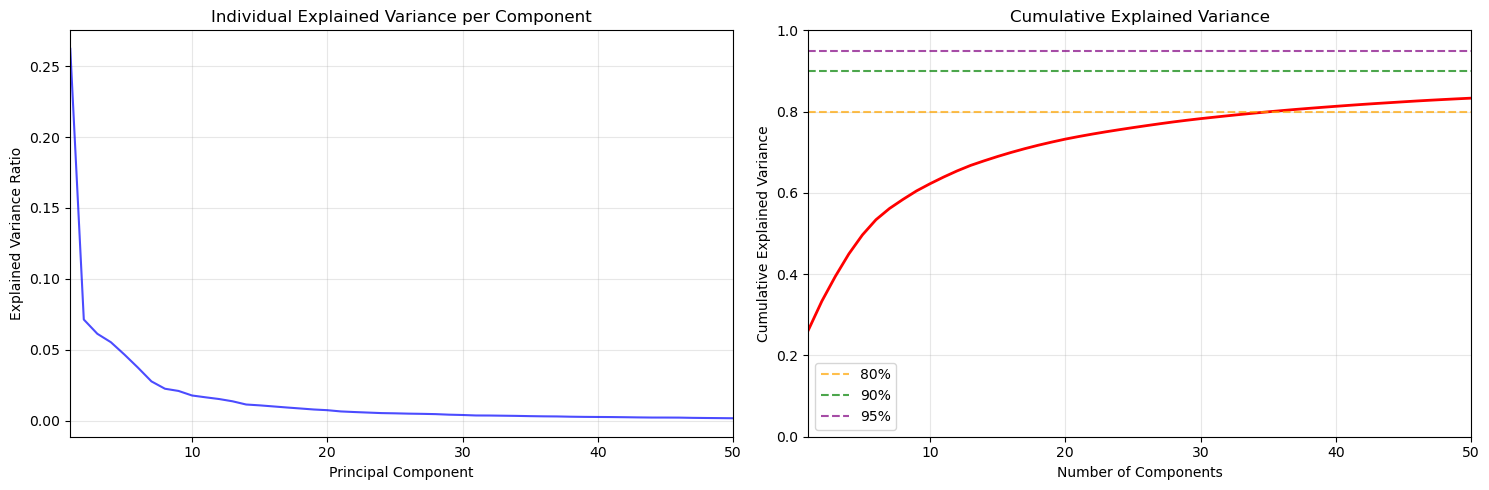


   • COMPONENT SELECTION RECOMMENDATIONS:
   • For meteorological clustering, typical ranges:
   • Conservative (high quality): 80-90% variance
   • Moderate (balanced): 90-95% variance
   • Aggressive (dimension reduction): 95%+ variance

   • MEMORY EFFICIENCY:
   • Original data: 5.27 GB
   • PCA data: 0.00 GB
   • Memory reduction: 15485.0x
   • Storage efficiency: 100.0% saved


In [11]:
# Visualization of explained variance
print("VARIANCE VISUALIZATION")

# Create plots for variance analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Individual explained variance ratio
ax1.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'b-', alpha=0.7)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Individual Explained Variance per Component')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, 50)  # Focus on first 50 components

# Plot 2: Cumulative explained variance
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'r-', linewidth=2)
ax2.axhline(y=0.80, color='orange', linestyle='--', alpha=0.7, label='80%')
ax2.axhline(y=0.90, color='green', linestyle='--', alpha=0.7, label='90%')
ax2.axhline(y=0.95, color='purple', linestyle='--', alpha=0.7, label='95%')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1, n_components)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Detailed analysis for optimal component selection
print("\n   • COMPONENT SELECTION RECOMMENDATIONS:")
print("   • For meteorological clustering, typical ranges:")
print("   • Conservative (high quality): 80-90% variance")
print("   • Moderate (balanced): 90-95% variance") 
print("   • Aggressive (dimension reduction): 95%+ variance")

# Memory usage comparison
original_memory = X.nbytes / (1024**3)  # GB
pca_memory = X_pca.nbytes / (1024**3)   # GB
reduction_factor = X.shape[1] / X_pca.shape[1]

print(f"\n   • MEMORY EFFICIENCY:")
print(f"   • Original data: {original_memory:.2f} GB")
print(f"   • PCA data: {pca_memory:.2f} GB") 
print(f"   • Memory reduction: {reduction_factor:.1f}x")
print(f"   • Storage efficiency: {(1 - pca_memory/original_memory)*100:.1f}% saved")

In [12]:
# Component selection for final analysis
print("COMPONENT SELECTION FOR CLUSTERING")

# Determine optimal number of components based on variance analysis
target_variance = 0.90  # 90% variance retention (good balance for meteorology)
optimal_components = np.argmax(cumulative_variance >= target_variance) + 1

print(f"   • Target variance retention: {target_variance*100}%")
print(f"   • Optimal components: {optimal_components}")
print(f"   • Actual variance captured: {cumulative_variance[optimal_components-1]:.3f}")

# Create reduced dataset with optimal components
X_reduced = X_pca[:, :optimal_components]
print(f"   • Reduced data shape: {X_reduced.shape}")

# Save memory by cleaning up intermediate results
del X_pca  # Keep only the reduced version
gc.collect()

print(f"   • Memory cleanup completed")
print(f"   • Ready for clustering analysis!")

# Summary statistics of the reduced dataset
print(f"\n   • REDUCED DATASET SUMMARY:")
print(f"   • Shape: {X_reduced.shape}")
print(f"   • Memory: {X_reduced.nbytes / (1024**2):.1f} MB")
print(f"   • Variance captured: {cumulative_variance[optimal_components-1]:.3f}")
print(f"   • Dimension reduction: {X.shape[1]} → {optimal_components} features")
print(f"   • Compression ratio: {X.shape[1]/optimal_components:.1f}:1")

COMPONENT SELECTION FOR CLUSTERING
   • Target variance retention: 90.0%
   • Optimal components: 1
   • Actual variance captured: 0.262
   • Reduced data shape: (1827, 1)
   • Memory cleanup completed
   • Ready for clustering analysis!

   • REDUCED DATASET SUMMARY:
   • Shape: (1827, 1)
   • Memory: 0.0 MB
   • Variance captured: 0.262
   • Dimension reduction: 774252 → 1 features
   • Compression ratio: 774252.0:1


Step 2: Analisi Varianza  (Plot varianza spiegata)
Guarda quante componenti servono per 90% varianza  
Plot: varianza cumulativa vs numero componenti  
Scegli dimensioni finali (probabilmente 20-80 componenti)  

3. Correlazione tra VARIABILI (non tutte le features)  
Analizza correlazioni tra le 4 variabili meteorologiche aggregate  
Invece di 774k×774k → 4×4 matrice gestibile  
Correlazioni tra variabili meteorologiche (aggregate per livello)
NON matrice completa (troppo grande)
Perché limitarsi:

❌ Matrice 774k×774k = 2.4 TB di memoria → IMPOSSIBILE  
✅ Correlazione z-u-v-t è meteorologicamente significat  